In [1]:
from model import atp_graph, losses
from data_wrangler import synthetic_data_gen, feature_extractor
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
from comparison_models.gru import gru_pipeline

from comparison_models.tnp import tnp_pipeline
from data_wrangler import dataset_preparer
import argparse
from data_wrangler.batcher import batcher, batcher_np
import os
import matplotlib.pyplot as plt
import numpy as np

2023-05-16 11:48:31.221737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
dataset = "ETT"
model = "atp"
iterations = 300
num_repeats = 1
n_C = 96
n_T = 192

In [19]:
if dataset == "ETT":
        x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data="datasets/ETTm2.csv") 
        save_dir = "weights/forecasting/ETT"
        print('make sure to create the ETT folder in weights/forecasting/')

    
save_dir = save_dir + "/" + model
save_dir = "weights/dummy"
    
batch_size = 32
test_batch_s = 100

nll_list = []
mse_list = []




   



make sure to create the ETT folder in weights/forecasting/


In [20]:
model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.05, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")      

In [21]:
save_dir = "weights/forecasting/ETT/atp/192"

In [22]:
run = 0

In [23]:
name_comp = 'run_' + str(run)

In [24]:
opt = tf.keras.optimizers.Adam(3e-4)

In [25]:

run = 0
tr_step = atp_graph.build_graph()

folder = save_dir + '/ckpt/check_' + name_comp
ckpt = tf.train.Checkpoint(step=tf.Variable(37), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [26]:
folder

'weights/forecasting/ETT/atp/192/ckpt/check_run_0'

In [27]:
array = []
train_array = []

idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])


model.summary()

Model: "atp_pipeline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper_1 (feature_  multiple                 0         
 wrapper)                                                        
                                                                 
 atp_1 (ATP)                 multiple                  91856     
                                                                 
 de_1 (DE)                   multiple                  4         
                                                                 
Total params: 91,860
Trainable params: 91,858
Non-trainable params: 2
_________________________________________________________________


In [45]:
model.weights

[<tf.Variable 'atp_pipeline_1/atp_1/mha_x_a_1/multi_head_attention_8/dense_53/kernel:0' shape=(34, 66) dtype=float32, numpy=
 array([[-0.1046595 ,  0.05602785, -0.0800577 , ...,  0.21868247,
         -0.11370457, -0.08860778],
        [-0.23481385, -0.11279382,  0.22716829, ..., -0.17256613,
          0.13343005,  0.05205701],
        [-0.20905007, -0.21812609, -0.1221335 , ..., -0.13785739,
          0.04353318, -0.03863214],
        ...,
        [-0.16908331,  0.14412396, -0.19961055, ..., -0.17885692,
         -0.26478288,  0.1731888 ],
        [-0.01271342,  0.01176838, -0.06046362, ..., -0.23999518,
          0.17027076,  0.0428196 ],
        [-0.10467955, -0.2353619 ,  0.06798597, ..., -0.03560879,
         -0.21382986, -0.08660617]], dtype=float32)>,
 <tf.Variable 'atp_pipeline_1/atp_1/mha_x_a_1/multi_head_attention_8/dense_53/bias:0' shape=(66,) dtype=float32, numpy=
 array([-0.03512219, -0.06235101, -0.00353969,  0.01841216,  0.0306075 ,
        -0.01460871,  0.02046598, -0.01

In [28]:
x_1 = x_test[0:288,:,:].transpose(1,0,2)
y_1 = y_test[0:96,:,:].transpose(1,0,2)

In [29]:
y_1_full =  y_test[0:288,:,:].transpose(1,0,2)

In [30]:
x_1.shape

(1, 288, 1)

In [31]:
x_1 = np.linspace(-1,1,288)[np.newaxis,:,np.newaxis]


In [32]:
n_C

96

In [33]:
%%time
y_temp = y_1.copy()
x_temp = x_1.copy()
num_samples = 20
y_temp = np.repeat(y_temp, num_samples, axis=0)
x_temp = np.repeat(x_temp, num_samples, axis=0)
μ = []
sample = True
# y_temp = y_1.copy()
for i in range(n_T):
    print(i)
    y_temp = np.concatenate([y_temp, np.zeros((num_samples, 1, 1))], axis=1)
    
    # print("y_temp step {} values {}".format(i,y_temp[:, 96:, :]))
    μ_tp1, log_σ_tp1  = model([x_temp[:, :y_temp.shape[1], :], y_temp, n_C, 1 + i, False])       # y_tp1 shape is (batch_size, n_T, 1) 
    if sample:
        μ.append(np.random.normal(μ_tp1.numpy()[:, -1, 0], np.exp(log_σ_tp1.numpy()[:, -1, 0])))
    else:
        μ.append(μ_tp1.numpy()[:, -1, 0])
    
    # print("mu value after sampling: ", μ[-1])
    y_temp[:, -1, :] =  μ[-1][:, np.newaxis]
    # print("y temp value after concat: ", y_temp[:, -1:, :])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
CPU times: user 26.4 s, sys: 1.36 s, total: 27.8 s
Wall time: 27.2 s


CPU times: user 39.8 ms, sys: 6.18 ms, total: 45.9 ms
Wall time: 40 ms


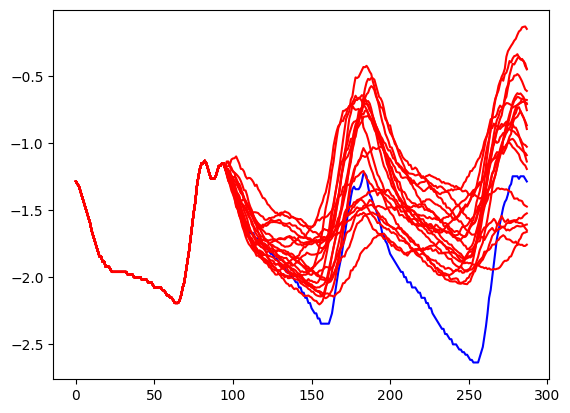

In [35]:
%%time
plt.plot(y_test[0:96+192,:,:].transpose(1,0,2).reshape(-1), color="blue")
for i in range(y_temp.shape[0]):
    plt.plot(y_temp[i, :, :].reshape(-1), color="red")


In [89]:
test_batch_s = 100

sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
    _,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)

print(msex)

tf.Tensor(0.0003012281, shape=(), dtype=float32)


In [116]:
 μ, log_σ = model([t_te, y_te, n_C, n_T, False])

In [106]:
t_te.shape

(144, 192, 1)

In [90]:
nllx

<tf.Tensor: shape=(), dtype=float32, numpy=-2.6979942>

In [93]:
y_te.shape

(144, 192, 1)

In [ ]:
μ_tp1, log_σ_tp1  = model([x_temp[:, :y_temp.shape[1], :], y_temp, n_C, 1 + i, False])       # y_tp1 shape is (batch_size, n_T, 1) 


In [107]:
y_1.shape

(1, 96, 1)

In [70]:
 μ, log_σ = model([x_1, y_1_full, 96, 96, False])

(20.0, 40.0)

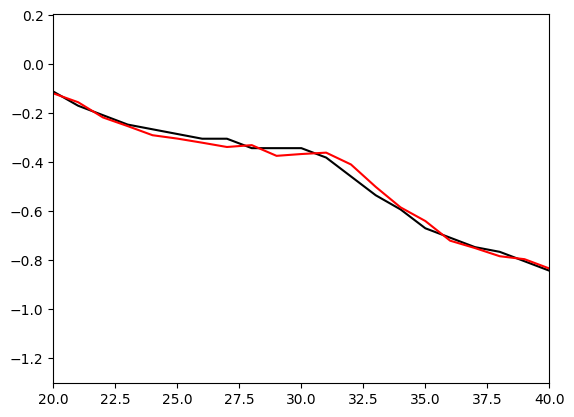

In [123]:
plt.plot(y_te[5,-96:],color="k")
plt.plot(μ[5],color="red")
plt.xlim([20,40])

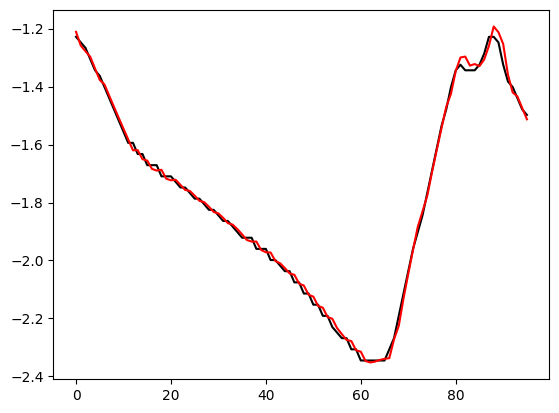

In [71]:
plt.plot(y_1_full[0,-96:],color="k")
plt.plot(μ[0],color="red")

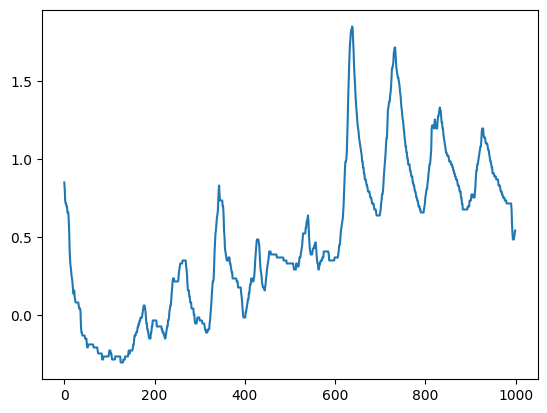

In [115]:
plt.plot(y_train[0:1000,0,0])

# TNP


In [22]:
i = 0
step = 1
run= 50 + i
tf.random.set_seed(run)



Model 9 

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=8,output_shape=48, dropout_rate=0.05, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)

-1.91

Model 10 


model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=12,output_shape=16, dropout_rate=0.15, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)
-1.39                
                 
Model 11


model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=8,output_shape=48, dropout_rate=0.3, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)
                 

-1.87

Model 12 

model = tnp_pipeline.tnp_pipeline(num_heads=7,projection_shape_for_head=12,output_shape=48, dropout_rate=0.05, 
                 permutation_repeats=0,bound_std=False, num_layers=4,target_y_dim=1)

-2.07                  

In [54]:
model = tnp_pipeline.tnp_pipeline(num_heads=7,projection_shape_for_head=12,output_shape=48, dropout_rate=0.05, 
                 permutation_repeats=0,bound_std=False, num_layers=4,target_y_dim=1)

                 

In [59]:
array = []
train_array = []

In [60]:
idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T)

In [61]:
μ, log_σ = model([x, y, n_C, n_T, False])


In [62]:
model.summary()

Model: "tnp_pipeline_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper_10 (feature  multiple                 0 (unused)
 _wrapper)                                                       
                                                                 
 tnp__decoder_4 (TNP_Decoder  multiple                 94946     
 )                                                               
                                                                 
Total params: 94,946
Trainable params: 94,946
Non-trainable params: 0
_________________________________________________________________


In [63]:

    run = 4
    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000

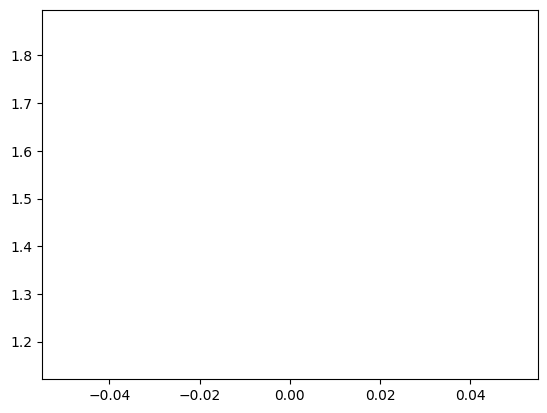

tf.Tensor(1.1561509, shape=(), dtype=float32)
tf.Tensor(1.1561509, shape=(), dtype=float32)


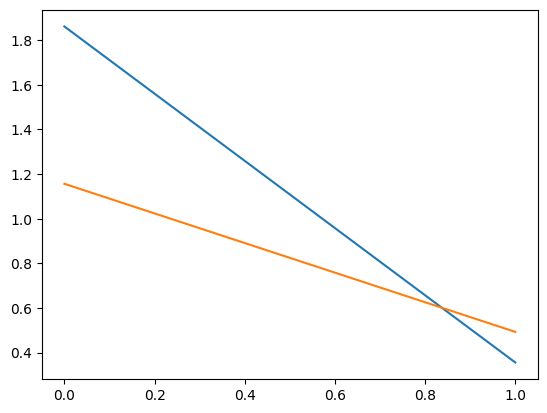

tf.Tensor(0.4929954, shape=(), dtype=float32)
tf.Tensor(0.4929954, shape=(), dtype=float32)


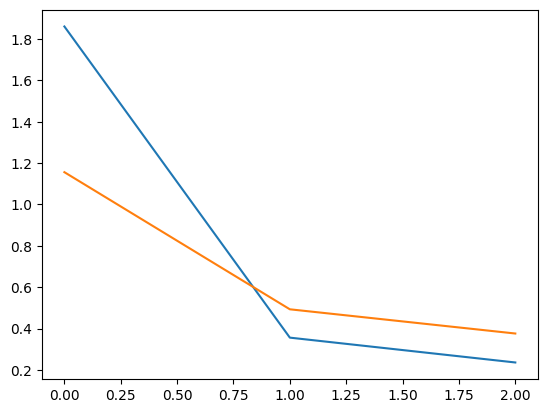

tf.Tensor(0.37587458, shape=(), dtype=float32)
tf.Tensor(0.37587458, shape=(), dtype=float32)


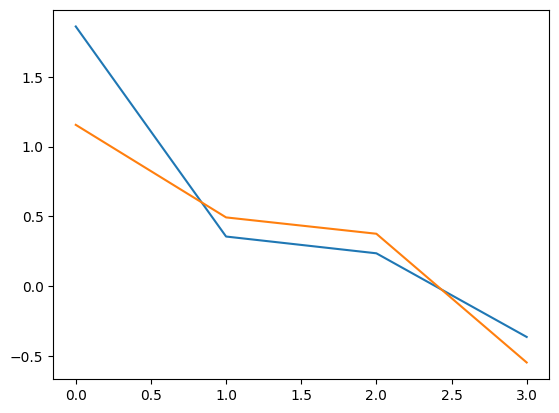

tf.Tensor(-0.54636055, shape=(), dtype=float32)
tf.Tensor(-0.54636055, shape=(), dtype=float32)


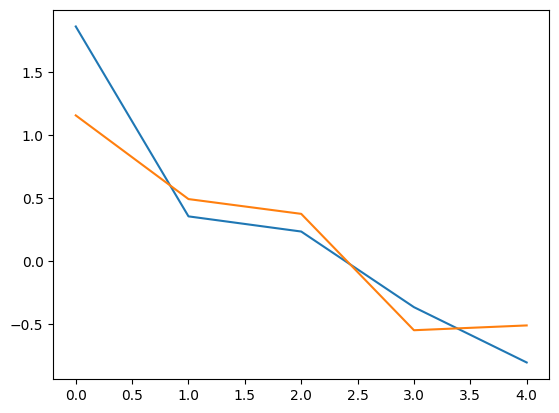

tf.Tensor(-0.50835925, shape=(), dtype=float32)
tf.Tensor(-0.54636055, shape=(), dtype=float32)


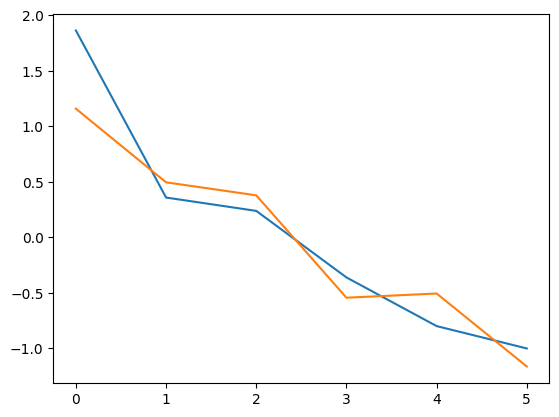

tf.Tensor(-1.1656935, shape=(), dtype=float32)
tf.Tensor(-1.1656935, shape=(), dtype=float32)


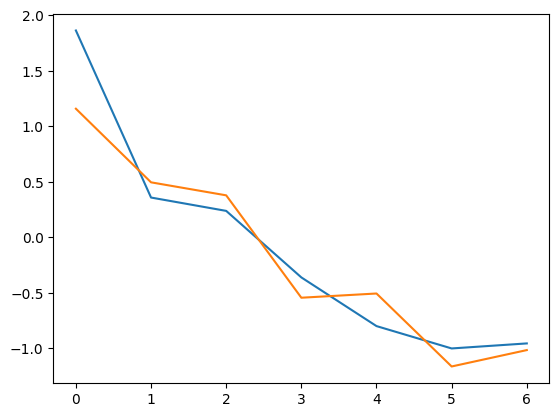

tf.Tensor(-1.0180573, shape=(), dtype=float32)
tf.Tensor(-1.1656935, shape=(), dtype=float32)


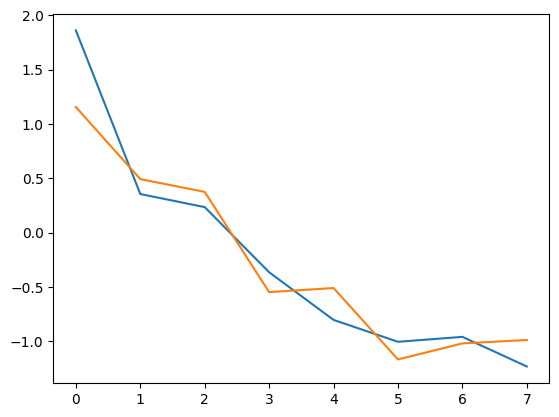

tf.Tensor(-0.98716795, shape=(), dtype=float32)
tf.Tensor(-1.1656935, shape=(), dtype=float32)


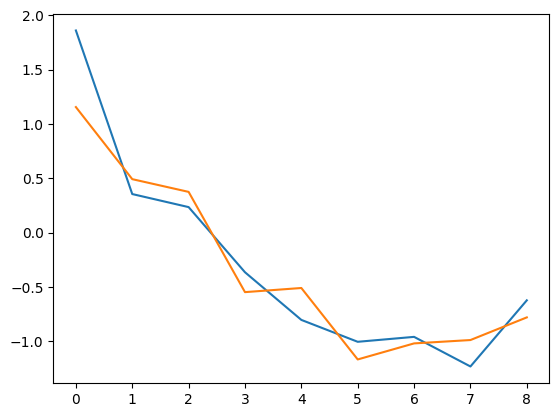

tf.Tensor(-0.7788021, shape=(), dtype=float32)
tf.Tensor(-1.1656935, shape=(), dtype=float32)


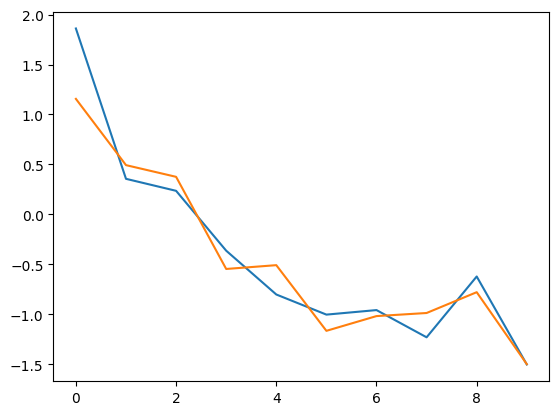

tf.Tensor(-1.4989388, shape=(), dtype=float32)
tf.Tensor(-1.4989388, shape=(), dtype=float32)


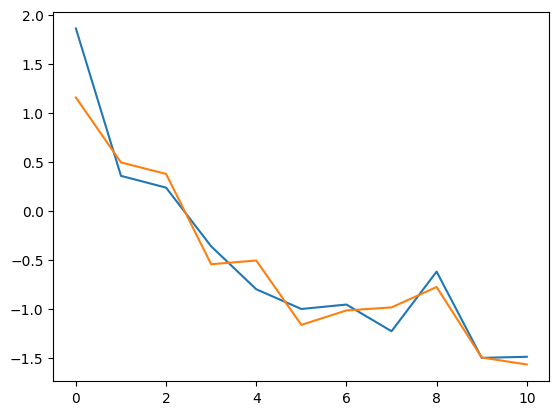

tf.Tensor(-1.5698773, shape=(), dtype=float32)
tf.Tensor(-1.5698773, shape=(), dtype=float32)


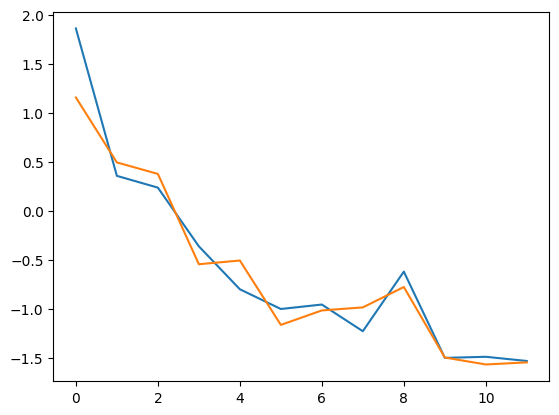

tf.Tensor(-1.5483395, shape=(), dtype=float32)
tf.Tensor(-1.5698773, shape=(), dtype=float32)


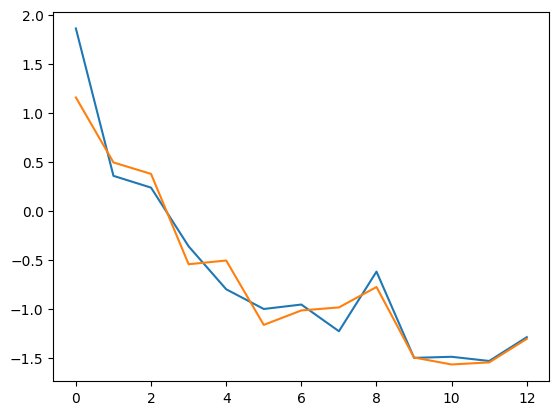

tf.Tensor(-1.3082733, shape=(), dtype=float32)
tf.Tensor(-1.5698773, shape=(), dtype=float32)


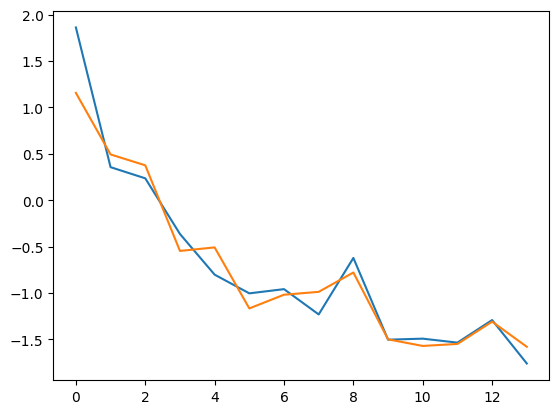

tf.Tensor(-1.5788753, shape=(), dtype=float32)
tf.Tensor(-1.5788753, shape=(), dtype=float32)


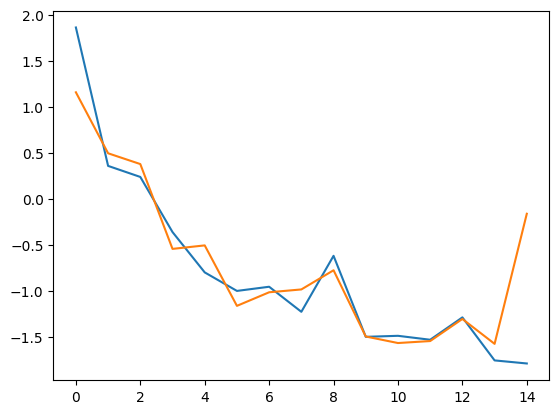

tf.Tensor(-0.16444488, shape=(), dtype=float32)
tf.Tensor(-1.5788753, shape=(), dtype=float32)


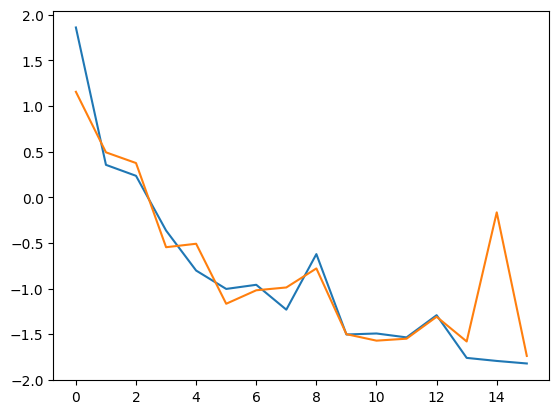

tf.Tensor(-1.7371826, shape=(), dtype=float32)
tf.Tensor(-1.7371826, shape=(), dtype=float32)


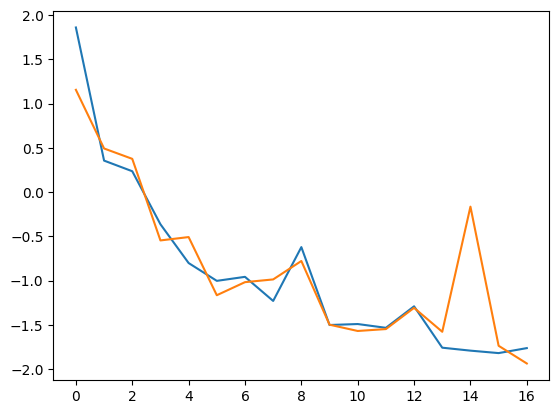

tf.Tensor(-1.9372725, shape=(), dtype=float32)
tf.Tensor(-1.9372725, shape=(), dtype=float32)


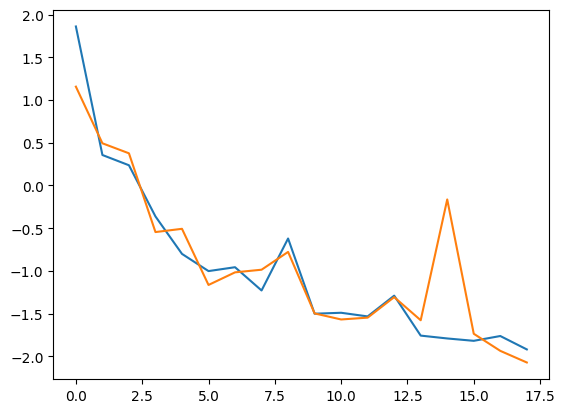

tf.Tensor(-2.0734189, shape=(), dtype=float32)
tf.Tensor(-2.0734189, shape=(), dtype=float32)


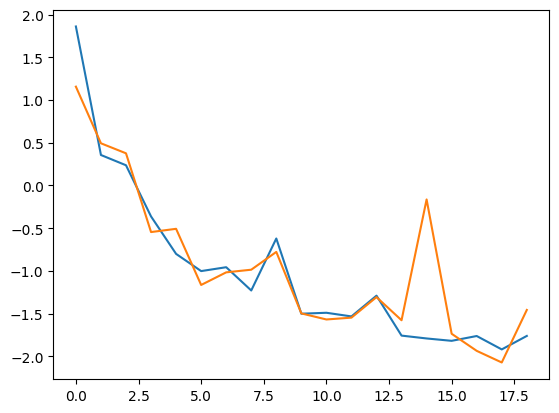

tf.Tensor(-1.4582856, shape=(), dtype=float32)
tf.Tensor(-2.0734189, shape=(), dtype=float32)


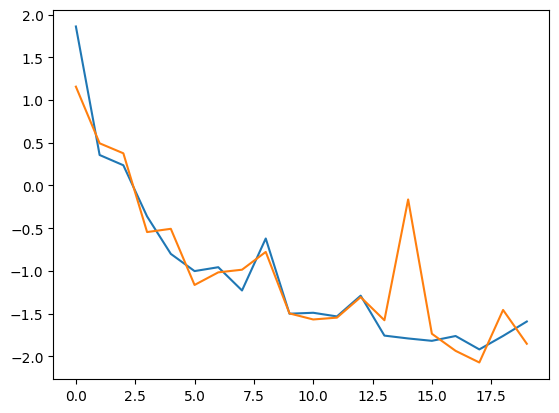

tf.Tensor(-1.8541793, shape=(), dtype=float32)
tf.Tensor(-2.0734189, shape=(), dtype=float32)


In [64]:
for i in range(2000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    _,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    x = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=32)
    #### edit batcher to fix this
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        _,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=100)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




In [37]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [169]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))

t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)


In [170]:
nll_pp_te

<tf.Tensor: shape=(), dtype=float32, numpy=0.11073752>

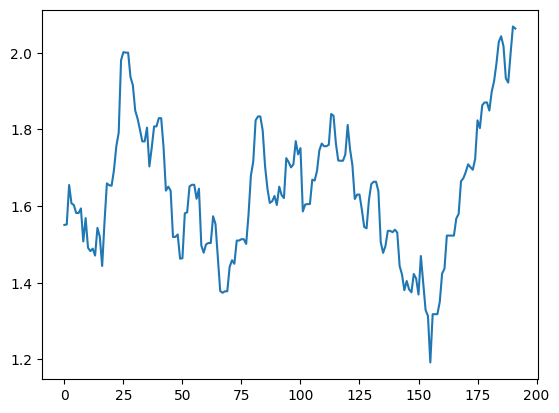

In [84]:
plt.plot(y_te[1,:,:])

In [41]:
test_batch_s = 100

sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
    _,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)

print(msex)

tf.Tensor(0.0030409105, shape=(), dtype=float32)


-0.5583371

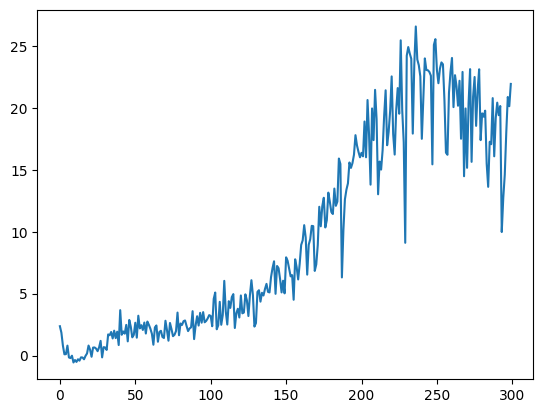

In [22]:
array = np.load("weights/forecasting/exchange/tnp/336/ckpt/check_run_1/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

-1.3766434

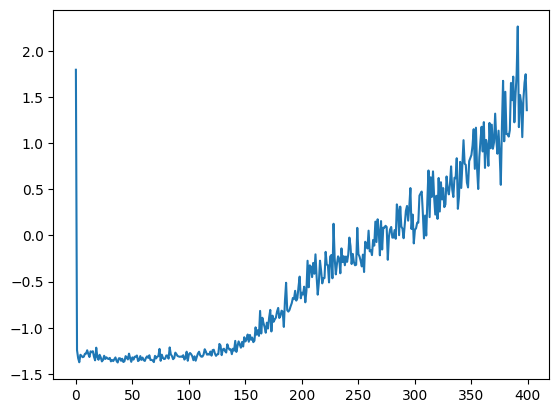

In [30]:
array = np.load("weights/forecasting/exchange/atp/96/ckpt/check_run_20/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

-2.714671

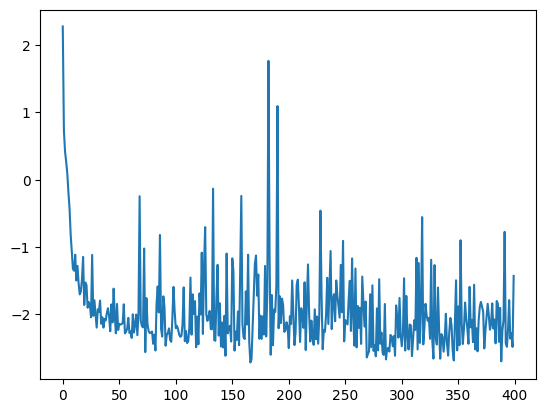

In [8]:
array = np.load("weights/forecasting/ETT/tnp/720/ckpt/check_run_1/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

In [24]:
array = np.load("weights/forecasting/ETT/gru/720/nll_list.npy")
array


array([-2.4779174], dtype=float32)

-2.7756588

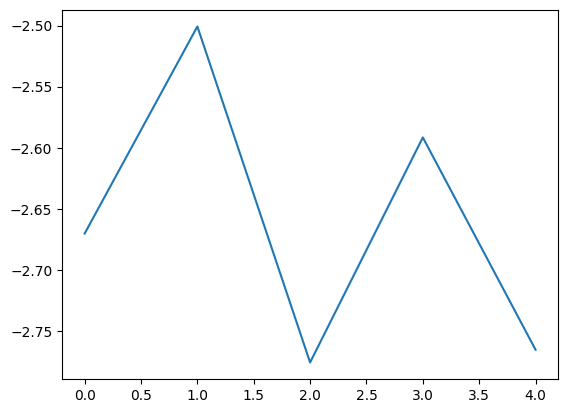

In [23]:
array = np.load("weights/forecasting/ETT/gru/720/ckpt/check_run_0/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

-1.2028567

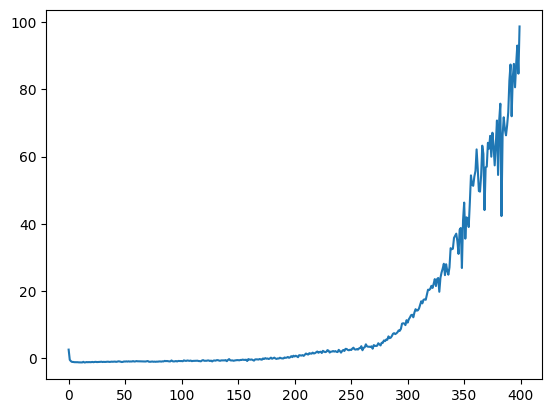

In [60]:
array = np.load("weights/forecasting/exchange/gru/336/ckpt/check_run_0/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

In [22]:
array = np.load("weights/forecasting/exchange/gru/192/mse_list.npy")
array
print(array.mean())
print(array.std())

array = np.load("weights/forecasting/exchange/gru/192/nll_list.npy")
array
print(array.mean())
print(array.std())

0.015318634
0.007175082
-0.6235019
0.3410422


In [34]:
array = np.load("weights/forecasting/exchange/atp/96/nll_list copy.npy")
array
print(array.mean())
print(array.std())

-1.3077542
0.018464327


# atp

In [4]:
i = 0
step = 1
run= 0 + i
tf.random.set_seed(run)


Model 1

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=8, output_shape=32, rate=0.1, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=2)
                 

Model 2

model = atp_pipeline.atp_pipeline(num_heads=7, projection_shape_for_head=15, output_shape=32, rate=0.1, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1)
                 

Model 3

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=12, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1)

-2.53

Model 4 

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=False)
                 

-2.54

Model 5

model = atp_pipeline.atp_pipeline(num_heads=3, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=False)
                 
-2.16

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=2,MHAX_leakage=False)
                 

-2.53

Model 7 

model = atp_pipeline.atp_pipeline(num_heads=8, projection_shape_for_head=12, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")      

-2.4

Model 8

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")      

-2.45

model 9 

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.0, permutation_repeats=1,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")      
0.05

In [37]:
model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.0, permutation_repeats=1,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")      

array = []
train_array = []

idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])


model.summary()

Model: "atp_pipeline_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper_8 (feature_  multiple                 0         
 wrapper)                                                        
                                                                 
 atp_8 (ATP)                 multiple                  91856     
                                                                 
 de_8 (DE)                   multiple                  4         
                                                                 
Total params: 91,860
Trainable params: 91,858
Non-trainable params: 2
_________________________________________________________________


In [38]:

    run = 10
    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000

2023-05-09 11:05:24.512534: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: atp_pipeline_8/cond/branch_executed/_10


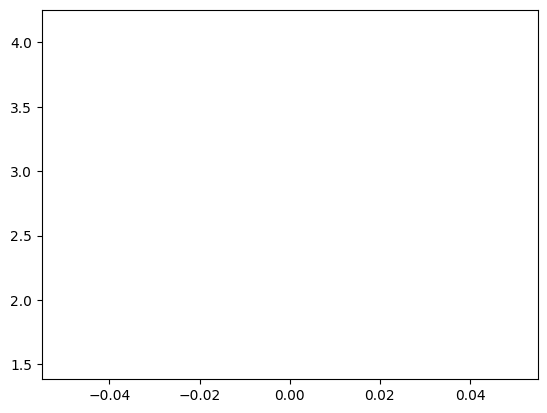

tf.Tensor(4.122299, shape=(), dtype=float32)
tf.Tensor(4.122299, shape=(), dtype=float32)


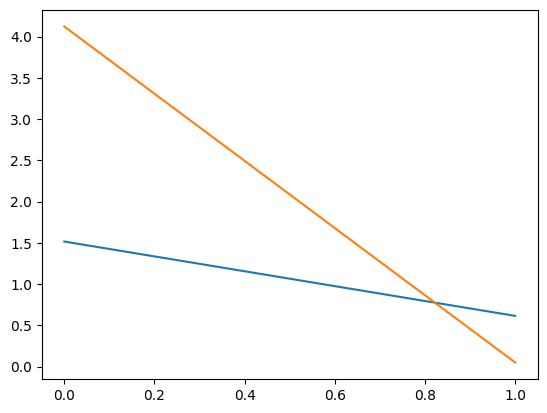

tf.Tensor(0.049531594, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


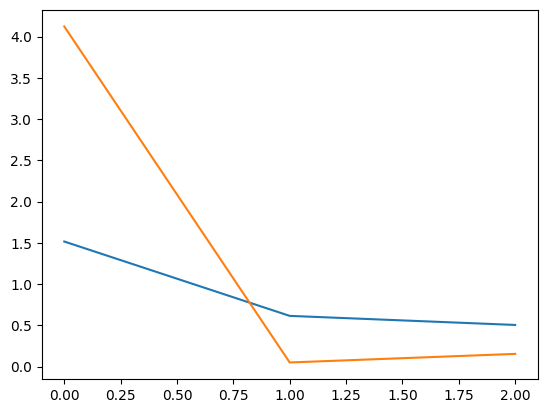

tf.Tensor(0.15355459, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


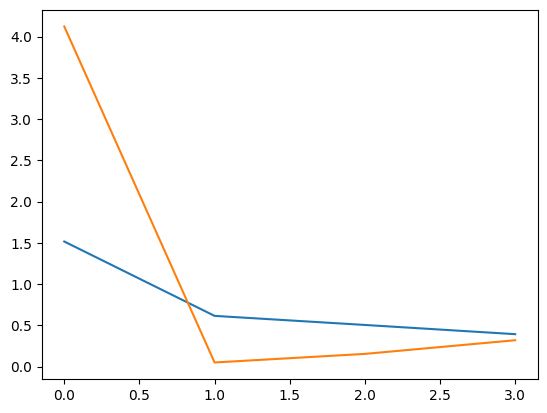

tf.Tensor(0.31918105, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


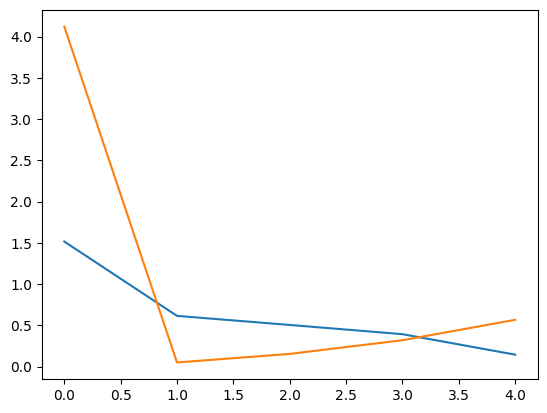

tf.Tensor(0.56655824, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


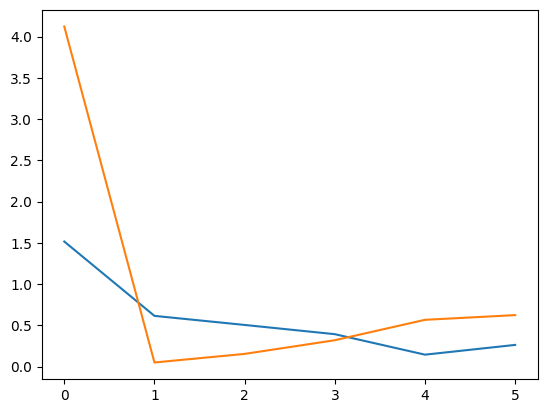

tf.Tensor(0.62361765, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


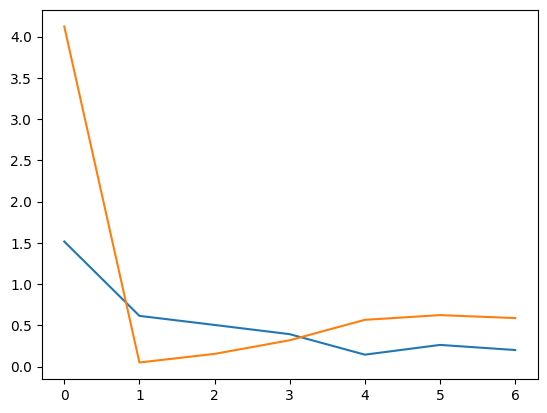

tf.Tensor(0.58780897, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


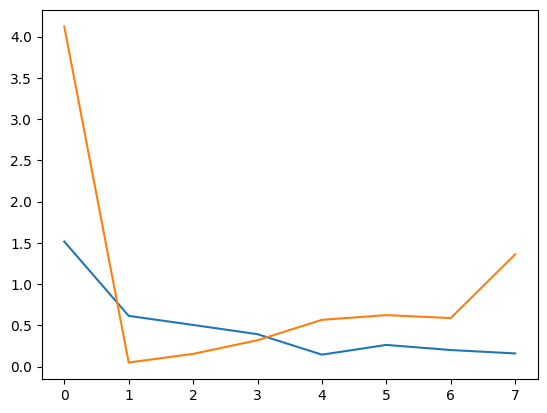

tf.Tensor(1.3599917, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


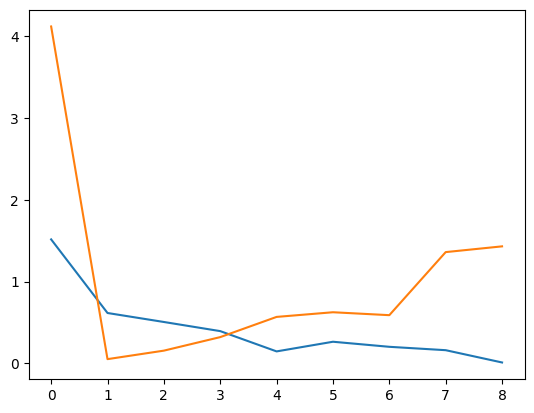

tf.Tensor(1.4302661, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


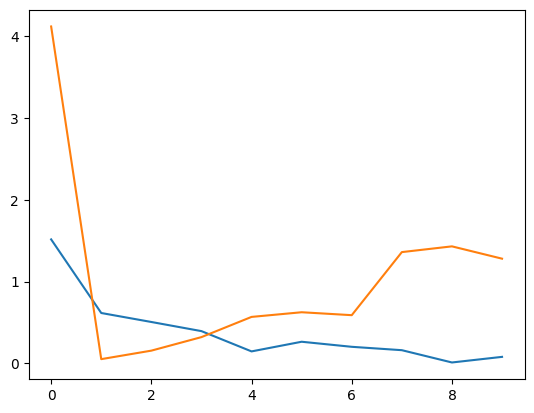

tf.Tensor(1.2794894, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


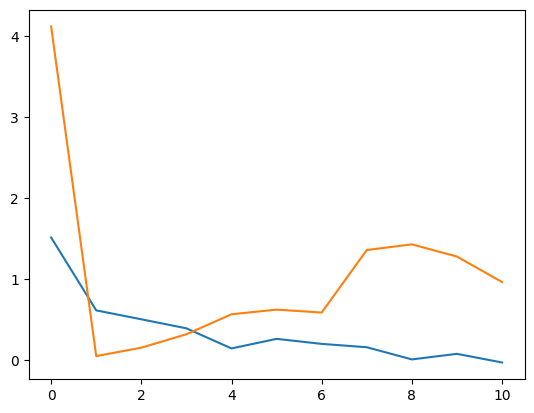

tf.Tensor(0.96406484, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


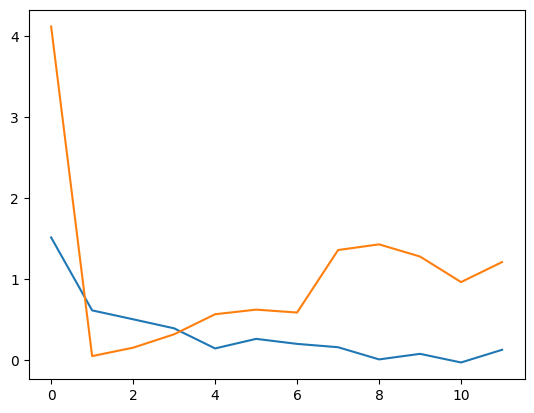

tf.Tensor(1.2114886, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


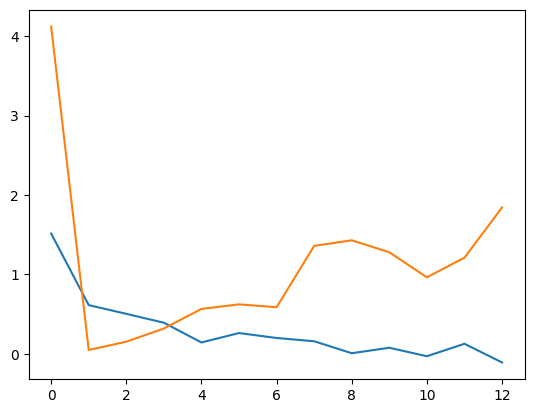

tf.Tensor(1.8438148, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


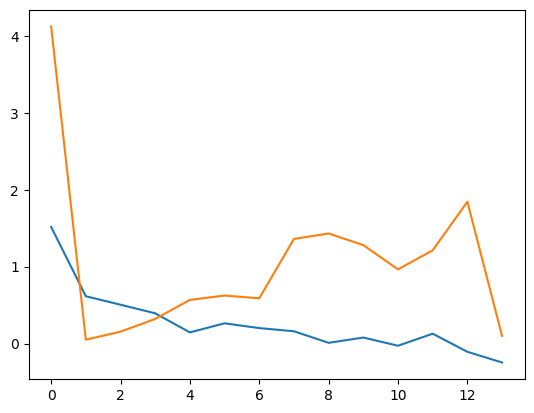

tf.Tensor(0.098277114, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


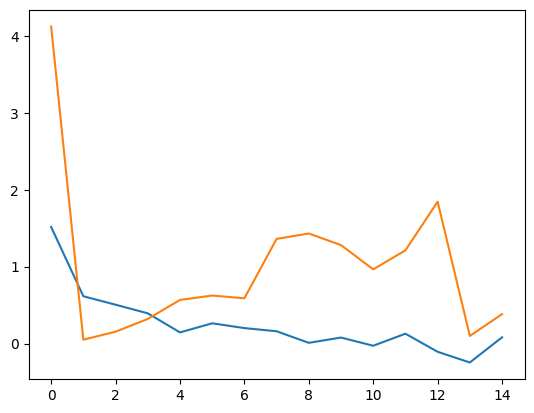

tf.Tensor(0.3823665, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


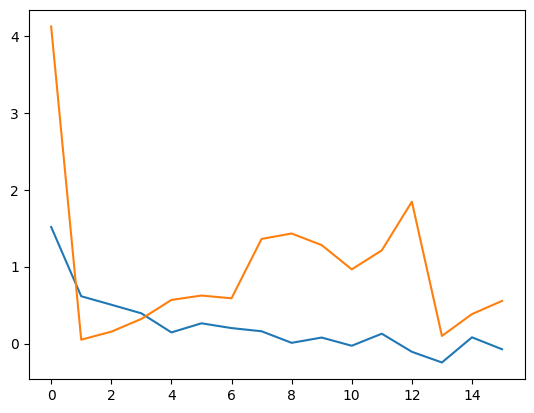

tf.Tensor(0.553909, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


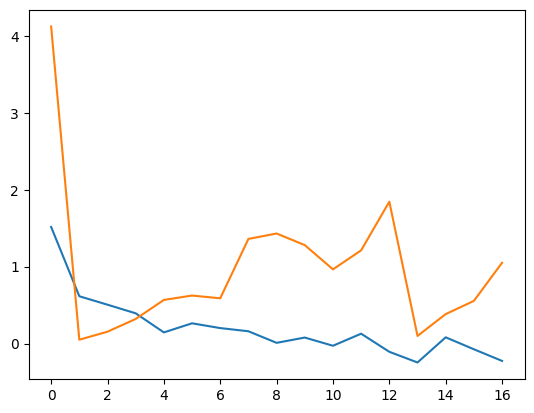

tf.Tensor(1.0495828, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


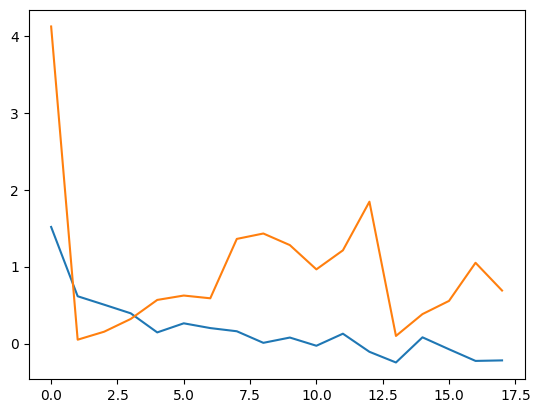

tf.Tensor(0.68871725, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


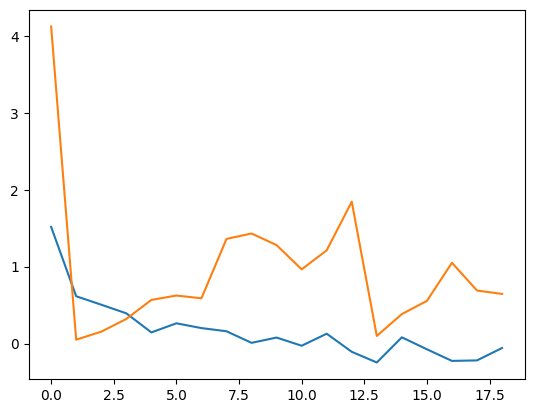

tf.Tensor(0.6448646, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


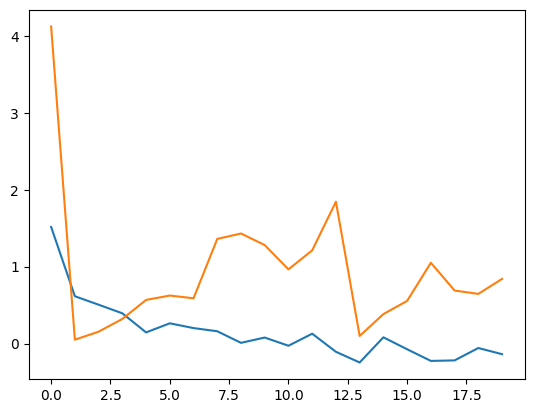

tf.Tensor(0.8402024, shape=(), dtype=float32)
tf.Tensor(0.049531594, shape=(), dtype=float32)


In [39]:
for i in range(2000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    _,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    x = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=32)
    #### edit batcher to fix this
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        _,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=100)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




In [153]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [154]:
test_batch_s = 100

sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
    _,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)

print(msex)

tf.Tensor(0.002536377, shape=(), dtype=float32)


In [23]:
model = gru_pipeline.gru_pipeline(rnn_units=[128, 64, 32], permutation_repeats=0, num_layers=3)

2023-05-12 12:11:25.462847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 12:11:29.956325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7395 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


In [25]:
array = []
train_array = []

idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])


model.summary()

Model: "gru_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper (feature_wr  multiple                 0 (unused)
 apper)                                                          
                                                                 
 gru_model (gru_model)       multiple                  97026     
                                                                 
Total params: 97,026
Trainable params: 97,026
Non-trainable params: 0
_________________________________________________________________
